<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


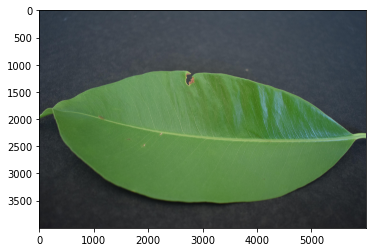

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

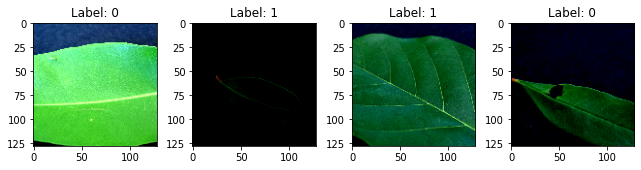

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:19] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:21] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2607319771076804 samples/sec                   batch loss = 0.5067263245582581 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.272203733786853 samples/sec                   batch loss = 0.6384654641151428 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.269966670332872 samples/sec                   batch loss = 0.2368001788854599 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.266315843500261 samples/sec                   batch loss = 0.9033116102218628 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.2705254388451355 samples/sec                   batch loss = 0.14343607425689697 | accuracy = 0.66


Epoch[1] Batch[30] Speed: 1.272270977110034 samples/sec                   batch loss = 1.105980634689331 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2628375414329127 samples/sec                   batch loss = 1.093623161315918 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2672061217873865 samples/sec                   batch loss = 0.8933455348014832 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.264954060901133 samples/sec                   batch loss = 1.2015151977539062 | accuracy = 0.6388888888888888


Epoch[1] Batch[50] Speed: 1.2694199188087143 samples/sec                   batch loss = 0.5697180032730103 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.2658721284154415 samples/sec                   batch loss = 0.397455096244812 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2655401188854671 samples/sec                   batch loss = 0.5395128726959229 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2710544615997927 samples/sec                   batch loss = 0.46533918380737305 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.270889142805892 samples/sec                   batch loss = 0.6309289932250977 | accuracy = 0.6321428571428571


Epoch[1] Batch[75] Speed: 1.2645964144928405 samples/sec                   batch loss = 0.507016658782959 | accuracy = 0.6366666666666667


Epoch[1] Batch[80] Speed: 1.265072812572718 samples/sec                   batch loss = 0.6323493719100952 | accuracy = 0.646875


Epoch[1] Batch[85] Speed: 1.2657374702506108 samples/sec                   batch loss = 0.7117042541503906 | accuracy = 0.6470588235294118


Epoch[1] Batch[90] Speed: 1.2726382877368008 samples/sec                   batch loss = 0.5218974947929382 | accuracy = 0.6527777777777778


Epoch[1] Batch[95] Speed: 1.2746889258105192 samples/sec                   batch loss = 0.40598738193511963 | accuracy = 0.6526315789473685


Epoch[1] Batch[100] Speed: 1.2731751587047004 samples/sec                   batch loss = 0.81904137134552 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2670807490943552 samples/sec                   batch loss = 0.976296067237854 | accuracy = 0.6547619047619048


Epoch[1] Batch[110] Speed: 1.2712748251347128 samples/sec                   batch loss = 0.3825538754463196 | accuracy = 0.6636363636363637


Epoch[1] Batch[115] Speed: 1.267971432805899 samples/sec                   batch loss = 0.3393150866031647 | accuracy = 0.6673913043478261


Epoch[1] Batch[120] Speed: 1.2744686357663848 samples/sec                   batch loss = 0.551174521446228 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.2700850189734345 samples/sec                   batch loss = 0.5226820707321167 | accuracy = 0.666


Epoch[1] Batch[130] Speed: 1.2678850963412498 samples/sec                   batch loss = 0.6047883629798889 | accuracy = 0.6692307692307692


Epoch[1] Batch[135] Speed: 1.2675166935019848 samples/sec                   batch loss = 0.4250585734844208 | accuracy = 0.6666666666666666


Epoch[1] Batch[140] Speed: 1.2656837104899514 samples/sec                   batch loss = 0.39457541704177856 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.2671885106901084 samples/sec                   batch loss = 0.38363346457481384 | accuracy = 0.6672413793103448


Epoch[1] Batch[150] Speed: 1.2661727773414366 samples/sec                   batch loss = 0.8082517981529236 | accuracy = 0.6666666666666666


Epoch[1] Batch[155] Speed: 1.2732895642676607 samples/sec                   batch loss = 0.464631587266922 | accuracy = 0.6661290322580645


Epoch[1] Batch[160] Speed: 1.2669281341493261 samples/sec                   batch loss = 1.1155548095703125 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.264740936114858 samples/sec                   batch loss = 0.22831279039382935 | accuracy = 0.6727272727272727


Epoch[1] Batch[170] Speed: 1.2634687369504307 samples/sec                   batch loss = 0.5317223072052002 | accuracy = 0.6647058823529411


Epoch[1] Batch[175] Speed: 1.2712756921001882 samples/sec                   batch loss = 0.3240105211734772 | accuracy = 0.6671428571428571


Epoch[1] Batch[180] Speed: 1.2683647430439666 samples/sec                   batch loss = 0.5429654121398926 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.266896754567494 samples/sec                   batch loss = 0.5253754258155823 | accuracy = 0.6675675675675675


Epoch[1] Batch[190] Speed: 1.2640896106462747 samples/sec                   batch loss = 0.7508839964866638 | accuracy = 0.6684210526315789


Epoch[1] Batch[195] Speed: 1.2649542516489922 samples/sec                   batch loss = 0.9124065637588501 | accuracy = 0.6692307692307692


Epoch[1] Batch[200] Speed: 1.2687841080124684 samples/sec                   batch loss = 0.364993155002594 | accuracy = 0.67125


Epoch[1] Batch[205] Speed: 1.2684158538977939 samples/sec                   batch loss = 0.9605222940444946 | accuracy = 0.6682926829268293


Epoch[1] Batch[210] Speed: 1.2724891568284582 samples/sec                   batch loss = 1.0306164026260376 | accuracy = 0.6642857142857143


Epoch[1] Batch[215] Speed: 1.266554454572522 samples/sec                   batch loss = 0.47050338983535767 | accuracy = 0.6674418604651163


Epoch[1] Batch[220] Speed: 1.2628035126515822 samples/sec                   batch loss = 0.3154661953449249 | accuracy = 0.6681818181818182


Epoch[1] Batch[225] Speed: 1.2714336922180347 samples/sec                   batch loss = 0.35261884331703186 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.2753822467586955 samples/sec                   batch loss = 0.32218441367149353 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.269259634053638 samples/sec                   batch loss = 0.4344286322593689 | accuracy = 0.675531914893617


Epoch[1] Batch[240] Speed: 1.2768415045089194 samples/sec                   batch loss = 0.5738177299499512 | accuracy = 0.6739583333333333


Epoch[1] Batch[245] Speed: 1.2731861732107381 samples/sec                   batch loss = 0.5702532529830933 | accuracy = 0.673469387755102


Epoch[1] Batch[250] Speed: 1.2710295214150982 samples/sec                   batch loss = 0.9848324656486511 | accuracy = 0.672


Epoch[1] Batch[255] Speed: 1.2682145987710034 samples/sec                   batch loss = 0.27873218059539795 | accuracy = 0.6725490196078432


Epoch[1] Batch[260] Speed: 1.2744747350810057 samples/sec                   batch loss = 0.6351462602615356 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.2733021269419658 samples/sec                   batch loss = 0.6493157148361206 | accuracy = 0.6735849056603773


Epoch[1] Batch[270] Speed: 1.2688168286037862 samples/sec                   batch loss = 0.6232703924179077 | accuracy = 0.674074074074074


Epoch[1] Batch[275] Speed: 1.2690816300132692 samples/sec                   batch loss = 0.5468343496322632 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.2737475856086369 samples/sec                   batch loss = 0.41660061478614807 | accuracy = 0.6758928571428572


Epoch[1] Batch[285] Speed: 1.2730953575377437 samples/sec                   batch loss = 0.43304309248924255 | accuracy = 0.6771929824561403


Epoch[1] Batch[290] Speed: 1.2611771200744384 samples/sec                   batch loss = 0.8441723585128784 | accuracy = 0.6767241379310345


Epoch[1] Batch[295] Speed: 1.2641484739354205 samples/sec                   batch loss = 0.9206951856613159 | accuracy = 0.6779661016949152


Epoch[1] Batch[300] Speed: 1.2690435202119639 samples/sec                   batch loss = 0.2953527867794037 | accuracy = 0.6783333333333333


Epoch[1] Batch[305] Speed: 1.270695763813744 samples/sec                   batch loss = 0.3866834342479706 | accuracy = 0.6778688524590164


Epoch[1] Batch[310] Speed: 1.2724621336087 samples/sec                   batch loss = 0.5136358737945557 | accuracy = 0.6806451612903226


Epoch[1] Batch[315] Speed: 1.2719685827729135 samples/sec                   batch loss = 0.6557800769805908 | accuracy = 0.6793650793650794


Epoch[1] Batch[320] Speed: 1.271693996327848 samples/sec                   batch loss = 0.6375138759613037 | accuracy = 0.67890625


Epoch[1] Batch[325] Speed: 1.2721958232749615 samples/sec                   batch loss = 0.20257720351219177 | accuracy = 0.6815384615384615


Epoch[1] Batch[330] Speed: 1.267742250168563 samples/sec                   batch loss = 0.49461159110069275 | accuracy = 0.6825757575757576


Epoch[1] Batch[335] Speed: 1.2718011943421683 samples/sec                   batch loss = 0.5255837440490723 | accuracy = 0.6828358208955224


Epoch[1] Batch[340] Speed: 1.2690271058642564 samples/sec                   batch loss = 0.5726691484451294 | accuracy = 0.6852941176470588


Epoch[1] Batch[345] Speed: 1.2782551162308042 samples/sec                   batch loss = 0.4212121069431305 | accuracy = 0.6869565217391305


Epoch[1] Batch[350] Speed: 1.2675240671216257 samples/sec                   batch loss = 0.47874119877815247 | accuracy = 0.6892857142857143


Epoch[1] Batch[355] Speed: 1.2750172266083861 samples/sec                   batch loss = 0.6142628192901611 | accuracy = 0.6894366197183098


Epoch[1] Batch[360] Speed: 1.2758735994146129 samples/sec                   batch loss = 1.0399260520935059 | accuracy = 0.6881944444444444


Epoch[1] Batch[365] Speed: 1.2696525909864984 samples/sec                   batch loss = 0.8760969638824463 | accuracy = 0.689041095890411


Epoch[1] Batch[370] Speed: 1.2697880835211148 samples/sec                   batch loss = 1.26846444606781 | accuracy = 0.6878378378378378


Epoch[1] Batch[375] Speed: 1.2769624987194006 samples/sec                   batch loss = 0.5784412622451782 | accuracy = 0.688


Epoch[1] Batch[380] Speed: 1.2729583856391322 samples/sec                   batch loss = 0.8145182728767395 | accuracy = 0.6881578947368421


Epoch[1] Batch[385] Speed: 1.2734663342251606 samples/sec                   batch loss = 0.5144399404525757 | accuracy = 0.6883116883116883


Epoch[1] Batch[390] Speed: 1.2551627695550225 samples/sec                   batch loss = 0.6098886728286743 | accuracy = 0.6871794871794872


Epoch[1] Batch[395] Speed: 1.2619640200840527 samples/sec                   batch loss = 0.3581983149051666 | accuracy = 0.6860759493670886


Epoch[1] Batch[400] Speed: 1.268537174760541 samples/sec                   batch loss = 1.0271378755569458 | accuracy = 0.6825


Epoch[1] Batch[405] Speed: 1.2771343596255047 samples/sec                   batch loss = 0.6129257082939148 | accuracy = 0.6808641975308642


Epoch[1] Batch[410] Speed: 1.2727093423264133 samples/sec                   batch loss = 0.5173560976982117 | accuracy = 0.6823170731707318


Epoch[1] Batch[415] Speed: 1.2738915949445901 samples/sec                   batch loss = 0.3911074697971344 | accuracy = 0.6807228915662651


Epoch[1] Batch[420] Speed: 1.2759294897754698 samples/sec                   batch loss = 0.42257460951805115 | accuracy = 0.6815476190476191


Epoch[1] Batch[425] Speed: 1.2719177637703776 samples/sec                   batch loss = 0.19745877385139465 | accuracy = 0.6817647058823529


Epoch[1] Batch[430] Speed: 1.2733374003911115 samples/sec                   batch loss = 0.7343197464942932 | accuracy = 0.6796511627906977


Epoch[1] Batch[435] Speed: 1.2750029828469203 samples/sec                   batch loss = 0.2836219370365143 | accuracy = 0.6798850574712644


Epoch[1] Batch[440] Speed: 1.2680947773187121 samples/sec                   batch loss = 0.7760293483734131 | accuracy = 0.6806818181818182


Epoch[1] Batch[445] Speed: 1.2735461819080585 samples/sec                   batch loss = 0.3872963488101959 | accuracy = 0.6814606741573034


Epoch[1] Batch[450] Speed: 1.273225208608704 samples/sec                   batch loss = 0.5515592694282532 | accuracy = 0.6822222222222222


Epoch[1] Batch[455] Speed: 1.2767109148055846 samples/sec                   batch loss = 0.47283974289894104 | accuracy = 0.6824175824175824


Epoch[1] Batch[460] Speed: 1.2715966468844238 samples/sec                   batch loss = 0.5069010257720947 | accuracy = 0.683695652173913


Epoch[1] Batch[465] Speed: 1.2723354293191391 samples/sec                   batch loss = 0.40797877311706543 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.277135429040652 samples/sec                   batch loss = 0.42660027742385864 | accuracy = 0.6856382978723404


Epoch[1] Batch[475] Speed: 1.277243643668761 samples/sec                   batch loss = 0.2380581647157669 | accuracy = 0.6863157894736842


Epoch[1] Batch[480] Speed: 1.278972992649259 samples/sec                   batch loss = 1.2947940826416016 | accuracy = 0.6854166666666667


Epoch[1] Batch[485] Speed: 1.2652224046382092 samples/sec                   batch loss = 0.20774056017398834 | accuracy = 0.6865979381443299


Epoch[1] Batch[490] Speed: 1.2743580837067094 samples/sec                   batch loss = 0.410561203956604 | accuracy = 0.688265306122449


Epoch[1] Batch[495] Speed: 1.265985607324195 samples/sec                   batch loss = 0.561670184135437 | accuracy = 0.6883838383838384


Epoch[1] Batch[500] Speed: 1.2686029758591222 samples/sec                   batch loss = 0.5815768837928772 | accuracy = 0.6875


Epoch[1] Batch[505] Speed: 1.272657112568816 samples/sec                   batch loss = 0.16453063488006592 | accuracy = 0.6896039603960396


Epoch[1] Batch[510] Speed: 1.2665900244995234 samples/sec                   batch loss = 1.5718016624450684 | accuracy = 0.6897058823529412


Epoch[1] Batch[515] Speed: 1.2675233967890223 samples/sec                   batch loss = 1.5474963188171387 | accuracy = 0.6902912621359223


Epoch[1] Batch[520] Speed: 1.2680983237085226 samples/sec                   batch loss = 0.928184986114502 | accuracy = 0.6899038461538461


Epoch[1] Batch[525] Speed: 1.27444172202761 samples/sec                   batch loss = 0.46154651045799255 | accuracy = 0.69


Epoch[1] Batch[530] Speed: 1.2772098063967616 samples/sec                   batch loss = 0.9406038522720337 | accuracy = 0.6910377358490566


Epoch[1] Batch[535] Speed: 1.2786809505361787 samples/sec                   batch loss = 0.5000531673431396 | accuracy = 0.6906542056074766


Epoch[1] Batch[540] Speed: 1.2730109299066914 samples/sec                   batch loss = 0.8614669442176819 | accuracy = 0.6902777777777778


Epoch[1] Batch[545] Speed: 1.274497874281599 samples/sec                   batch loss = 0.6988579034805298 | accuracy = 0.6903669724770642


Epoch[1] Batch[550] Speed: 1.2763117325216125 samples/sec                   batch loss = 0.3468398153781891 | accuracy = 0.6913636363636364


Epoch[1] Batch[555] Speed: 1.2763028970036747 samples/sec                   batch loss = 0.38717782497406006 | accuracy = 0.6923423423423424


Epoch[1] Batch[560] Speed: 1.2760097437000444 samples/sec                   batch loss = 0.6072496771812439 | accuracy = 0.6933035714285715


Epoch[1] Batch[565] Speed: 1.272784943080458 samples/sec                   batch loss = 0.40699175000190735 | accuracy = 0.6915929203539823


Epoch[1] Batch[570] Speed: 1.2766804088581623 samples/sec                   batch loss = 0.673190176486969 | accuracy = 0.6912280701754386


Epoch[1] Batch[575] Speed: 1.273259028339116 samples/sec                   batch loss = 0.7144067287445068 | accuracy = 0.6904347826086956


Epoch[1] Batch[580] Speed: 1.274033314892982 samples/sec                   batch loss = 0.37321361899375916 | accuracy = 0.690948275862069


Epoch[1] Batch[585] Speed: 1.2735956808984363 samples/sec                   batch loss = 0.6613057851791382 | accuracy = 0.6897435897435897


Epoch[1] Batch[590] Speed: 1.2765905510840418 samples/sec                   batch loss = 0.49146348237991333 | accuracy = 0.6902542372881356


Epoch[1] Batch[595] Speed: 1.2713830122924794 samples/sec                   batch loss = 0.749644935131073 | accuracy = 0.6903361344537815


Epoch[1] Batch[600] Speed: 1.2769799937556126 samples/sec                   batch loss = 0.5881855487823486 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.274405903347086 samples/sec                   batch loss = 0.36972472071647644 | accuracy = 0.6909090909090909


Epoch[1] Batch[610] Speed: 1.2808339414105223 samples/sec                   batch loss = 0.834252119064331 | accuracy = 0.690983606557377


Epoch[1] Batch[615] Speed: 1.2782183038016923 samples/sec                   batch loss = 1.313067078590393 | accuracy = 0.6894308943089431


Epoch[1] Batch[620] Speed: 1.273851454751218 samples/sec                   batch loss = 1.2083454132080078 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2752124078842486 samples/sec                   batch loss = 0.7084921002388 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.277770589019753 samples/sec                   batch loss = 0.38099148869514465 | accuracy = 0.6892857142857143


Epoch[1] Batch[635] Speed: 1.274471927452738 samples/sec                   batch loss = 0.5325106978416443 | accuracy = 0.6889763779527559


Epoch[1] Batch[640] Speed: 1.2792105457988765 samples/sec                   batch loss = 0.5546639561653137 | accuracy = 0.6875


Epoch[1] Batch[645] Speed: 1.2750855429490129 samples/sec                   batch loss = 1.8548214435577393 | accuracy = 0.687984496124031


Epoch[1] Batch[650] Speed: 1.277841439261879 samples/sec                   batch loss = 0.5050502419471741 | accuracy = 0.688076923076923


Epoch[1] Batch[655] Speed: 1.2728321619007705 samples/sec                   batch loss = 0.5158908367156982 | accuracy = 0.6881679389312977


Epoch[1] Batch[660] Speed: 1.2742728110277068 samples/sec                   batch loss = 0.2649902403354645 | accuracy = 0.6875


Epoch[1] Batch[665] Speed: 1.2796184731298073 samples/sec                   batch loss = 0.49329429864883423 | accuracy = 0.687593984962406


Epoch[1] Batch[670] Speed: 1.2807874959129 samples/sec                   batch loss = 0.5639775991439819 | accuracy = 0.6873134328358209


Epoch[1] Batch[675] Speed: 1.2740570185763733 samples/sec                   batch loss = 0.5734978914260864 | accuracy = 0.6877777777777778


Epoch[1] Batch[680] Speed: 1.2855336834682436 samples/sec                   batch loss = 0.3370152711868286 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.27895134810348 samples/sec                   batch loss = 0.5180373787879944 | accuracy = 0.6872262773722628


Epoch[1] Batch[690] Speed: 1.2659879955669484 samples/sec                   batch loss = 0.5747628211975098 | accuracy = 0.6880434782608695


Epoch[1] Batch[695] Speed: 1.2741026869345895 samples/sec                   batch loss = 0.31625819206237793 | accuracy = 0.6884892086330935


Epoch[1] Batch[700] Speed: 1.2746579353557614 samples/sec                   batch loss = 0.6520721912384033 | accuracy = 0.6896428571428571


Epoch[1] Batch[705] Speed: 1.2793424278307879 samples/sec                   batch loss = 0.7364491820335388 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2735807921256266 samples/sec                   batch loss = 0.4189707636833191 | accuracy = 0.6908450704225352


Epoch[1] Batch[715] Speed: 1.2765105154595249 samples/sec                   batch loss = 1.0537352561950684 | accuracy = 0.6905594405594405


Epoch[1] Batch[720] Speed: 1.2772273082101584 samples/sec                   batch loss = 0.5374042987823486 | accuracy = 0.6902777777777778


Epoch[1] Batch[725] Speed: 1.2680903683212021 samples/sec                   batch loss = 0.7646220922470093 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.272324526016491 samples/sec                   batch loss = 0.21114353835582733 | accuracy = 0.6910958904109589


Epoch[1] Batch[735] Speed: 1.2758960131899955 samples/sec                   batch loss = 0.4225175380706787 | accuracy = 0.6918367346938775


Epoch[1] Batch[740] Speed: 1.2718279002563788 samples/sec                   batch loss = 0.58941251039505 | accuracy = 0.6912162162162162


Epoch[1] Batch[745] Speed: 1.2688172124330537 samples/sec                   batch loss = 0.26676464080810547 | accuracy = 0.6916107382550336


Epoch[1] Batch[750] Speed: 1.277445245953965 samples/sec                   batch loss = 0.6396830081939697 | accuracy = 0.6916666666666667


Epoch[1] Batch[755] Speed: 1.2773840680576474 samples/sec                   batch loss = 0.5987514853477478 | accuracy = 0.6923841059602649


Epoch[1] Batch[760] Speed: 1.2763894126698638 samples/sec                   batch loss = 0.506089985370636 | accuracy = 0.6927631578947369


Epoch[1] Batch[765] Speed: 1.2756211834786793 samples/sec                   batch loss = 0.07812780141830444 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.2779142441234945 samples/sec                   batch loss = 0.2645099461078644 | accuracy = 0.6935064935064935


Epoch[1] Batch[775] Speed: 1.277488142059543 samples/sec                   batch loss = 1.0187222957611084 | accuracy = 0.6938709677419355


Epoch[1] Batch[780] Speed: 1.2786636037667847 samples/sec                   batch loss = 0.5831530690193176 | accuracy = 0.6935897435897436


Epoch[1] Batch[785] Speed: 1.277122401741742 samples/sec                   batch loss = 0.5789000988006592 | accuracy = 0.6929936305732484


[Epoch 1] training: accuracy=0.6932106598984772
[Epoch 1] time cost: 647.6795527935028
[Epoch 1] validation: validation accuracy=0.73


Epoch[2] Batch[5] Speed: 1.2635779786733197 samples/sec                   batch loss = 0.1323925107717514 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2647578118350769 samples/sec                   batch loss = 0.38540729880332947 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2705772051069322 samples/sec                   batch loss = 0.5941438674926758 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.270108479812447 samples/sec                   batch loss = 0.9485910534858704 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2756236082142502 samples/sec                   batch loss = 0.558937668800354 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2785390716799507 samples/sec                   batch loss = 0.5590971112251282 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2731316822522174 samples/sec                   batch loss = 0.21563579142093658 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2755503852641727 samples/sec                   batch loss = 0.27724960446357727 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2745039738760815 samples/sec                   batch loss = 0.47164297103881836 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2716880199920093 samples/sec                   batch loss = 0.8732768893241882 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2768225556853223 samples/sec                   batch loss = 0.5635452270507812 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2736681961319005 samples/sec                   batch loss = 0.5925883054733276 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.2730148902202878 samples/sec                   batch loss = 0.28985148668289185 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2760305123816034 samples/sec                   batch loss = 0.7514577507972717 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2803553720736391 samples/sec                   batch loss = 0.7432836294174194 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.2692094153443225 samples/sec                   batch loss = 1.045248031616211 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2752907297811784 samples/sec                   batch loss = 0.5633187890052795 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.2762356151491332 samples/sec                   batch loss = 0.6268738508224487 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2792238108087646 samples/sec                   batch loss = 0.2877175211906433 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.2689755618134113 samples/sec                   batch loss = 0.24116604030132294 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2701847335254572 samples/sec                   batch loss = 0.5927284955978394 | accuracy = 0.7166666666666667


Epoch[2] Batch[110] Speed: 1.268369729287404 samples/sec                   batch loss = 0.5403639674186707 | accuracy = 0.7159090909090909


Epoch[2] Batch[115] Speed: 1.2709509517881188 samples/sec                   batch loss = 0.350454717874527 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.2688156771173775 samples/sec                   batch loss = 0.45192041993141174 | accuracy = 0.7229166666666667


Epoch[2] Batch[125] Speed: 1.2742546158381043 samples/sec                   batch loss = 0.7461591958999634 | accuracy = 0.722


Epoch[2] Batch[130] Speed: 1.2631151631194695 samples/sec                   batch loss = 0.7189080119132996 | accuracy = 0.7230769230769231


Epoch[2] Batch[135] Speed: 1.2643266211669681 samples/sec                   batch loss = 0.13657599687576294 | accuracy = 0.7277777777777777


Epoch[2] Batch[140] Speed: 1.269571981844681 samples/sec                   batch loss = 0.2254173755645752 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.270360738582177 samples/sec                   batch loss = 0.34061649441719055 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2669546357995976 samples/sec                   batch loss = 0.9969934821128845 | accuracy = 0.7216666666666667


Epoch[2] Batch[155] Speed: 1.269125406312337 samples/sec                   batch loss = 0.21442772448062897 | accuracy = 0.7225806451612903


Epoch[2] Batch[160] Speed: 1.2684428014283917 samples/sec                   batch loss = 0.36684343218803406 | accuracy = 0.7203125


Epoch[2] Batch[165] Speed: 1.269745318569754 samples/sec                   batch loss = 1.2507810592651367 | accuracy = 0.7212121212121212


Epoch[2] Batch[170] Speed: 1.270865364315981 samples/sec                   batch loss = 0.7721882462501526 | accuracy = 0.7161764705882353


Epoch[2] Batch[175] Speed: 1.2698241236381185 samples/sec                   batch loss = 0.17147868871688843 | accuracy = 0.7185714285714285


Epoch[2] Batch[180] Speed: 1.2705629641533491 samples/sec                   batch loss = 0.7378296256065369 | accuracy = 0.7194444444444444


Epoch[2] Batch[185] Speed: 1.2715374734177665 samples/sec                   batch loss = 0.7271647453308105 | accuracy = 0.7202702702702702


Epoch[2] Batch[190] Speed: 1.2709502778259871 samples/sec                   batch loss = 0.4263109266757965 | accuracy = 0.7223684210526315


Epoch[2] Batch[195] Speed: 1.2730622227044845 samples/sec                   batch loss = 0.1185210794210434 | accuracy = 0.7243589743589743


Epoch[2] Batch[200] Speed: 1.2718745659898585 samples/sec                   batch loss = 0.344376802444458 | accuracy = 0.72625


Epoch[2] Batch[205] Speed: 1.26766734304441 samples/sec                   batch loss = 1.5451784133911133 | accuracy = 0.724390243902439


Epoch[2] Batch[210] Speed: 1.2681881402464836 samples/sec                   batch loss = 0.33873385190963745 | accuracy = 0.7273809523809524


Epoch[2] Batch[215] Speed: 1.2693078400709357 samples/sec                   batch loss = 0.36925631761550903 | accuracy = 0.727906976744186


Epoch[2] Batch[220] Speed: 1.2715246564381124 samples/sec                   batch loss = 0.6032719016075134 | accuracy = 0.725


Epoch[2] Batch[225] Speed: 1.2675174595883436 samples/sec                   batch loss = 0.471500962972641 | accuracy = 0.7255555555555555


Epoch[2] Batch[230] Speed: 1.2701631930872275 samples/sec                   batch loss = 0.36650675535202026 | accuracy = 0.725


Epoch[2] Batch[235] Speed: 1.2659016424366236 samples/sec                   batch loss = 0.3940817415714264 | accuracy = 0.723404255319149


Epoch[2] Batch[240] Speed: 1.2663666937694986 samples/sec                   batch loss = 0.6414281129837036 | accuracy = 0.7260416666666667


Epoch[2] Batch[245] Speed: 1.268045896669308 samples/sec                   batch loss = 0.6436445116996765 | accuracy = 0.7285714285714285


Epoch[2] Batch[250] Speed: 1.2674808799982957 samples/sec                   batch loss = 0.35205504298210144 | accuracy = 0.729


Epoch[2] Batch[255] Speed: 1.2676280730253775 samples/sec                   batch loss = 0.5379820466041565 | accuracy = 0.7284313725490196


Epoch[2] Batch[260] Speed: 1.2765181883429375 samples/sec                   batch loss = 0.6391951441764832 | accuracy = 0.7269230769230769


Epoch[2] Batch[265] Speed: 1.268655448974007 samples/sec                   batch loss = 0.5529243350028992 | accuracy = 0.7254716981132076


Epoch[2] Batch[270] Speed: 1.2641285664814415 samples/sec                   batch loss = 0.43252408504486084 | accuracy = 0.7268518518518519


Epoch[2] Batch[275] Speed: 1.2715052869065442 samples/sec                   batch loss = 0.2418975979089737 | accuracy = 0.7272727272727273


Epoch[2] Batch[280] Speed: 1.2737447811832274 samples/sec                   batch loss = 0.47780129313468933 | accuracy = 0.7285714285714285


Epoch[2] Batch[285] Speed: 1.2714105677964496 samples/sec                   batch loss = 0.3246009945869446 | accuracy = 0.7298245614035088


Epoch[2] Batch[290] Speed: 1.2690044528420055 samples/sec                   batch loss = 0.938693642616272 | accuracy = 0.7275862068965517


Epoch[2] Batch[295] Speed: 1.2679702828534187 samples/sec                   batch loss = 1.0259442329406738 | accuracy = 0.726271186440678


Epoch[2] Batch[300] Speed: 1.273669646520798 samples/sec                   batch loss = 0.5536574125289917 | accuracy = 0.7291666666666666


Epoch[2] Batch[305] Speed: 1.2705732599459303 samples/sec                   batch loss = 0.19536928832530975 | accuracy = 0.730327868852459


Epoch[2] Batch[310] Speed: 1.2715649392442772 samples/sec                   batch loss = 0.6950265169143677 | accuracy = 0.7314516129032258


Epoch[2] Batch[315] Speed: 1.2747435501557298 samples/sec                   batch loss = 0.2510221004486084 | accuracy = 0.7317460317460317


Epoch[2] Batch[320] Speed: 1.2704596305802065 samples/sec                   batch loss = 0.5774233937263489 | accuracy = 0.7328125


Epoch[2] Batch[325] Speed: 1.2669310043106212 samples/sec                   batch loss = 0.5862593650817871 | accuracy = 0.7338461538461538


Epoch[2] Batch[330] Speed: 1.2717797918559082 samples/sec                   batch loss = 0.7058395743370056 | accuracy = 0.7348484848484849


Epoch[2] Batch[335] Speed: 1.2714485308316046 samples/sec                   batch loss = 0.2296842634677887 | accuracy = 0.7373134328358208


Epoch[2] Batch[340] Speed: 1.2699870504924817 samples/sec                   batch loss = 0.27957308292388916 | accuracy = 0.7389705882352942


Epoch[2] Batch[345] Speed: 1.2666914862621577 samples/sec                   batch loss = 0.5002667307853699 | accuracy = 0.7391304347826086


Epoch[2] Batch[350] Speed: 1.2688074248592756 samples/sec                   batch loss = 0.3670561909675598 | accuracy = 0.7421428571428571


Epoch[2] Batch[355] Speed: 1.2698957294070745 samples/sec                   batch loss = 0.695544421672821 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2705670054725995 samples/sec                   batch loss = 0.3418281674385071 | accuracy = 0.7444444444444445


Epoch[2] Batch[365] Speed: 1.2714750292173274 samples/sec                   batch loss = 0.31885167956352234 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2688642332750049 samples/sec                   batch loss = 0.3797256648540497 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.26905724715625 samples/sec                   batch loss = 0.375080406665802 | accuracy = 0.7446666666666667


Epoch[2] Batch[380] Speed: 1.2666842179611049 samples/sec                   batch loss = 0.4722432494163513 | accuracy = 0.7447368421052631


Epoch[2] Batch[385] Speed: 1.2644664113899846 samples/sec                   batch loss = 0.6740533709526062 | accuracy = 0.7435064935064936


Epoch[2] Batch[390] Speed: 1.2728763904764548 samples/sec                   batch loss = 0.8461791276931763 | accuracy = 0.7416666666666667


Epoch[2] Batch[395] Speed: 1.2706016464064975 samples/sec                   batch loss = 0.5082231163978577 | accuracy = 0.7411392405063291


Epoch[2] Batch[400] Speed: 1.2652151531865712 samples/sec                   batch loss = 1.0670201778411865 | accuracy = 0.74


Epoch[2] Batch[405] Speed: 1.2719329994018345 samples/sec                   batch loss = 0.7142189145088196 | accuracy = 0.7364197530864197


Epoch[2] Batch[410] Speed: 1.2662282032795016 samples/sec                   batch loss = 0.28375110030174255 | accuracy = 0.7365853658536585


Epoch[2] Batch[415] Speed: 1.2630877758287096 samples/sec                   batch loss = 0.3393726944923401 | accuracy = 0.7367469879518073


Epoch[2] Batch[420] Speed: 1.26707070121193 samples/sec                   batch loss = 0.3529992699623108 | accuracy = 0.7392857142857143


Epoch[2] Batch[425] Speed: 1.2619801572968021 samples/sec                   batch loss = 0.16960522532463074 | accuracy = 0.7405882352941177


Epoch[2] Batch[430] Speed: 1.2732916902412712 samples/sec                   batch loss = 0.7022789716720581 | accuracy = 0.7406976744186047


Epoch[2] Batch[435] Speed: 1.2721934115530993 samples/sec                   batch loss = 0.7135069966316223 | accuracy = 0.7419540229885058


Epoch[2] Batch[440] Speed: 1.2771630400154077 samples/sec                   batch loss = 0.8719795942306519 | accuracy = 0.7403409090909091


Epoch[2] Batch[445] Speed: 1.2732171887647485 samples/sec                   batch loss = 0.6243351101875305 | accuracy = 0.7398876404494382


Epoch[2] Batch[450] Speed: 1.2760198368066404 samples/sec                   batch loss = 0.632498025894165 | accuracy = 0.7394444444444445


Epoch[2] Batch[455] Speed: 1.268387181448173 samples/sec                   batch loss = 0.4175216555595398 | accuracy = 0.7406593406593407


Epoch[2] Batch[460] Speed: 1.2685496438322605 samples/sec                   batch loss = 0.9113596677780151 | accuracy = 0.7385869565217391


Epoch[2] Batch[465] Speed: 1.2699729188971838 samples/sec                   batch loss = 0.2083173245191574 | accuracy = 0.7403225806451613


Epoch[2] Batch[470] Speed: 1.2676693545011317 samples/sec                   batch loss = 0.35121601819992065 | accuracy = 0.7377659574468085


Epoch[2] Batch[475] Speed: 1.2806712502662148 samples/sec                   batch loss = 0.4721924066543579 | accuracy = 0.7363157894736843


Epoch[2] Batch[480] Speed: 1.2679553336609806 samples/sec                   batch loss = 0.7028310298919678 | accuracy = 0.7354166666666667


Epoch[2] Batch[485] Speed: 1.2701036721928625 samples/sec                   batch loss = 0.5970791578292847 | accuracy = 0.7360824742268042


Epoch[2] Batch[490] Speed: 1.2663566572086784 samples/sec                   batch loss = 0.28201377391815186 | accuracy = 0.7372448979591837


Epoch[2] Batch[495] Speed: 1.2750305016930017 samples/sec                   batch loss = 0.3516440689563751 | accuracy = 0.7378787878787879


Epoch[2] Batch[500] Speed: 1.275049591167836 samples/sec                   batch loss = 0.5701786875724792 | accuracy = 0.7395


Epoch[2] Batch[505] Speed: 1.2688296870106623 samples/sec                   batch loss = 0.3035525977611542 | accuracy = 0.7415841584158416


Epoch[2] Batch[510] Speed: 1.273368423313613 samples/sec                   batch loss = 0.4831857681274414 | accuracy = 0.7431372549019608


Epoch[2] Batch[515] Speed: 1.2674698682315189 samples/sec                   batch loss = 0.5270665287971497 | accuracy = 0.7417475728155339


Epoch[2] Batch[520] Speed: 1.2681378145785218 samples/sec                   batch loss = 0.28780022263526917 | accuracy = 0.7423076923076923


Epoch[2] Batch[525] Speed: 1.2722195551057645 samples/sec                   batch loss = 0.7474037408828735 | accuracy = 0.7423809523809524


Epoch[2] Batch[530] Speed: 1.2698030759612804 samples/sec                   batch loss = 0.5127140879631042 | accuracy = 0.7429245283018868


Epoch[2] Batch[535] Speed: 1.2721045700926508 samples/sec                   batch loss = 0.35918372869491577 | accuracy = 0.7439252336448599


Epoch[2] Batch[540] Speed: 1.26895694171473 samples/sec                   batch loss = 1.0555057525634766 | accuracy = 0.7453703703703703


Epoch[2] Batch[545] Speed: 1.2727340588261533 samples/sec                   batch loss = 1.2616193294525146 | accuracy = 0.7458715596330275


Epoch[2] Batch[550] Speed: 1.2750256567395757 samples/sec                   batch loss = 0.10665856301784515 | accuracy = 0.7459090909090909


Epoch[2] Batch[555] Speed: 1.2686034554840249 samples/sec                   batch loss = 0.49299222230911255 | accuracy = 0.7454954954954955


Epoch[2] Batch[560] Speed: 1.2715078887496079 samples/sec                   batch loss = 0.27874475717544556 | accuracy = 0.7459821428571428


Epoch[2] Batch[565] Speed: 1.269311009120658 samples/sec                   batch loss = 0.30442824959754944 | accuracy = 0.7473451327433628


Epoch[2] Batch[570] Speed: 1.2706410046485308 samples/sec                   batch loss = 0.4736838638782501 | accuracy = 0.7473684210526316


Epoch[2] Batch[575] Speed: 1.2701751171681146 samples/sec                   batch loss = 0.6174114942550659 | accuracy = 0.7473913043478261


Epoch[2] Batch[580] Speed: 1.266828356293059 samples/sec                   batch loss = 1.021121621131897 | accuracy = 0.7474137931034482


Epoch[2] Batch[585] Speed: 1.2715204162911977 samples/sec                   batch loss = 0.4188916087150574 | accuracy = 0.747008547008547


Epoch[2] Batch[590] Speed: 1.2754898735679434 samples/sec                   batch loss = 0.6516755819320679 | accuracy = 0.7466101694915255


Epoch[2] Batch[595] Speed: 1.274519368350347 samples/sec                   batch loss = 0.24356496334075928 | accuracy = 0.7478991596638656


Epoch[2] Batch[600] Speed: 1.2763421237536101 samples/sec                   batch loss = 0.2040182650089264 | accuracy = 0.7483333333333333


Epoch[2] Batch[605] Speed: 1.274190356135303 samples/sec                   batch loss = 0.19299767911434174 | accuracy = 0.7495867768595041


Epoch[2] Batch[610] Speed: 1.2748280140324257 samples/sec                   batch loss = 0.6483820080757141 | accuracy = 0.7483606557377049


Epoch[2] Batch[615] Speed: 1.2686989080573028 samples/sec                   batch loss = 0.27044492959976196 | accuracy = 0.7479674796747967


Epoch[2] Batch[620] Speed: 1.266907469371885 samples/sec                   batch loss = 0.6501163244247437 | accuracy = 0.7467741935483871


Epoch[2] Batch[625] Speed: 1.26876472593613 samples/sec                   batch loss = 0.7911749482154846 | accuracy = 0.7468


Epoch[2] Batch[630] Speed: 1.2702403189241112 samples/sec                   batch loss = 0.3412870764732361 | accuracy = 0.746031746031746


Epoch[2] Batch[635] Speed: 1.2700980953997407 samples/sec                   batch loss = 0.43380922079086304 | accuracy = 0.7452755905511811


Epoch[2] Batch[640] Speed: 1.26970351741262 samples/sec                   batch loss = 0.4640551209449768 | accuracy = 0.745703125


Epoch[2] Batch[645] Speed: 1.2731730331202096 samples/sec                   batch loss = 0.2008470594882965 | accuracy = 0.7449612403100775


Epoch[2] Batch[650] Speed: 1.2704242277844267 samples/sec                   batch loss = 0.38778990507125854 | accuracy = 0.7446153846153846


Epoch[2] Batch[655] Speed: 1.2701810792925143 samples/sec                   batch loss = 0.6792101263999939 | accuracy = 0.7435114503816794


Epoch[2] Batch[660] Speed: 1.271930974391811 samples/sec                   batch loss = 0.4721664488315582 | accuracy = 0.7420454545454546


Epoch[2] Batch[665] Speed: 1.2684210323379315 samples/sec                   batch loss = 0.6143485903739929 | accuracy = 0.7409774436090225


Epoch[2] Batch[670] Speed: 1.2690147233917088 samples/sec                   batch loss = 0.5326734185218811 | accuracy = 0.7417910447761195


Epoch[2] Batch[675] Speed: 1.265854076828363 samples/sec                   batch loss = 0.7628702521324158 | accuracy = 0.74


Epoch[2] Batch[680] Speed: 1.2657926670829336 samples/sec                   batch loss = 0.7662545442581177 | accuracy = 0.7389705882352942


Epoch[2] Batch[685] Speed: 1.276560050888262 samples/sec                   batch loss = 0.31449559330940247 | accuracy = 0.7394160583941606


Epoch[2] Batch[690] Speed: 1.270127614499088 samples/sec                   batch loss = 0.18748053908348083 | accuracy = 0.7398550724637681


Epoch[2] Batch[695] Speed: 1.2707019233121533 samples/sec                   batch loss = 0.44678258895874023 | accuracy = 0.7406474820143885


Epoch[2] Batch[700] Speed: 1.2721775908844193 samples/sec                   batch loss = 0.26863572001457214 | accuracy = 0.7410714285714286


Epoch[2] Batch[705] Speed: 1.2693790994961893 samples/sec                   batch loss = 0.5197315812110901 | accuracy = 0.7421985815602837


Epoch[2] Batch[710] Speed: 1.2713484250812437 samples/sec                   batch loss = 0.6965988278388977 | accuracy = 0.7415492957746479


Epoch[2] Batch[715] Speed: 1.2673164894281996 samples/sec                   batch loss = 0.5555170178413391 | accuracy = 0.7416083916083916


Epoch[2] Batch[720] Speed: 1.2652113366664641 samples/sec                   batch loss = 0.29741761088371277 | accuracy = 0.7416666666666667


Epoch[2] Batch[725] Speed: 1.2693429885988334 samples/sec                   batch loss = 0.403374046087265 | accuracy = 0.743103448275862


Epoch[2] Batch[730] Speed: 1.2694216476846045 samples/sec                   batch loss = 0.8339164853096008 | accuracy = 0.7438356164383562


Epoch[2] Batch[735] Speed: 1.2635050853222092 samples/sec                   batch loss = 0.47619393467903137 | accuracy = 0.7438775510204082


Epoch[2] Batch[740] Speed: 1.2661861555718756 samples/sec                   batch loss = 0.1982284039258957 | accuracy = 0.7449324324324325


Epoch[2] Batch[745] Speed: 1.268806273389935 samples/sec                   batch loss = 0.7040662169456482 | accuracy = 0.7449664429530202


Epoch[2] Batch[750] Speed: 1.2710195070989658 samples/sec                   batch loss = 0.7719832062721252 | accuracy = 0.744


Epoch[2] Batch[755] Speed: 1.261542130994466 samples/sec                   batch loss = 0.2442156970500946 | accuracy = 0.7440397350993377


Epoch[2] Batch[760] Speed: 1.2643199516494463 samples/sec                   batch loss = 0.29457271099090576 | accuracy = 0.7440789473684211


Epoch[2] Batch[765] Speed: 1.2700301201513116 samples/sec                   batch loss = 0.2599252760410309 | accuracy = 0.7441176470588236


Epoch[2] Batch[770] Speed: 1.2714460255868303 samples/sec                   batch loss = 0.40965816378593445 | accuracy = 0.7441558441558441


Epoch[2] Batch[775] Speed: 1.2707568802301497 samples/sec                   batch loss = 0.6011154055595398 | accuracy = 0.7435483870967742


Epoch[2] Batch[780] Speed: 1.270295620644654 samples/sec                   batch loss = 0.5282185673713684 | accuracy = 0.7442307692307693


Epoch[2] Batch[785] Speed: 1.2729870719534595 samples/sec                   batch loss = 0.5234119892120361 | accuracy = 0.7436305732484076


[Epoch 2] training: accuracy=0.7436548223350253
[Epoch 2] time cost: 637.864396572113
[Epoch 2] validation: validation accuracy=0.7677777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7311111111111112

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)